# Training Neural Networks to Emulate Audio Effects

I'm gearing up to start a new job at an AI lab, working on RL systems, and I want to do a bit of hands-on NN work to gear up.

Let's figure out how to train a model to emulate various audio effects, like distortion units or reverbs or whatever. For boilerplate stuff like loading audio data, I'll write a type signature and comment and have Claude fill out the details.

I haven't read any literature on how to do stuff like this, so I'll probably do some stupid stuff here, call things by the wrong name, etc., but I find it's often more educational to go in blind sometimes. Basically everything I know about NNs is just from discussions with [my friend who works on neural compression codecs](https://danjacobellis.net).

I figure an architecture that might work pretty well is to have the previous `m` input samples, $[i_n, i_{n+1}, ..., i_{n+m-1}, i_{n+m}]$, and the previous `m-1` output samples, $[o_n, o_{n+1}, ..., o_{n+m-1}]$, and train the network to generate the next output sample, $o_{n+m}$

```
                     .-------.
[m prev inputs]----->|  The  |
[m-1 prev outputs]-->| Model |-->[next output]
                     '-------'
```

This architecture seems good to me because:

1. It's easy to generate examples of input data
2. It gives the model enough context to (theoretically) recover information like "what is the current phase of this oscillator"


As for how to actually represent the audio, some initial thoughts:

1. You could just pass in and extract straight up $[-1,1]$ float audio into/out of the model.
   1. The model will have to grow hardware to implement a threshold detector ADC or something, which seems kind of wasteful
   2. This fails to accurately capture entropy density in human audio perception. A signal with peak amplitude 0.01 is often just as clear to humans as a signal with peak amplitude 1.0. Which brings us to a possible improvement
2. Pre- and post-process the audio with some sort of compander, like a $\mu$-law
   1. This will probably help the model maintain perceptual accuracy across wide volume ranges
3. Encode a binary representation of the audio. This feels to me like it will probably be difficult for the model to reason about.
4. Use some sort of one-hot encoding for the amplitude, probably in combination with a companding algorithm. This might be too expensive on the input side (since we have a lot of inputs), but could work well on the output side. We could have 256 different outputs for 8-bit audio, for example.
   1. We could also possibly allow the network to output a continuous "residual" value for adding additional accuracy on top of the one-hot value.
  
For now, let's just try the first thing and see how it goes. I expect it will work OK for well-normalized (loud) audio and poorly for quiet audio.

As for our loss function: probably some sort of perceptual similarity metric would be best, but let's start with a super simple metric like squared error in $\mu$-law space.

First up, I need a bunch of training data. I took a bunch of songs from my music library and put them in the `examples` folder. (I'm old enought that I have about 75GB of local music files.) 

When we want to train a new effect, we'll have a bunch of training runs of the form:

1. Pick a bunch of random song slices from the library
2. Feed the song slices through the reference implementation of the effect (could be software or hardware)
3. Train the model to predict the next sample of the effect across all I/O examples in the batch

In [4]:
import os
import numpy as np
import torchaudio
import random
from pathlib import Path
from typing import List, Tuple

def list_audio_files(examples_dir: str = "examples") -> List[str]:
    """
    List all audio files in the examples directory.
    
    Args:
        examples_dir: Path to the examples directory
        
    Returns:
        List of audio file paths
    """
    audio_extensions = {'.mp3', '.m4a', '.wav', '.flac', '.aac', '.ogg', '.mp4'}
    audio_files = []
    
    examples_path = Path(examples_dir)
    if not examples_path.exists():
        raise FileNotFoundError(f"Examples directory '{examples_dir}' not found")
    
    for file_path in examples_path.rglob('*'):
        if file_path.is_file() and file_path.suffix.lower() in audio_extensions:
            audio_files.append(str(file_path))
    
    return sorted(audio_files)

def read_audio_normalized(file_path: str) -> np.ndarray:
    """
    Read an audio file, convert to mono, and normalize so peak absolute value is 1.0.
    
    Args:
        file_path: Path to the audio file
        
    Returns:
        Normalized mono audio as float32 numpy array with shape (samples,)
    """
    # Load audio using torchaudio (handles many formats)
    try:
        waveform, sample_rate = torchaudio.load(file_path)
        
        # Convert to numpy float32
        audio = waveform.numpy().astype(np.float32)
        
        # Convert to mono by averaging channels if stereo/multi-channel
        if audio.shape[0] > 1:
            audio = np.mean(audio, axis=0)
        else:
            audio = audio.squeeze(0)
        
        # Normalize to peak amplitude of 1.0
        peak = np.max(np.abs(audio))
        if peak > 0:  # Avoid division by zero for silent audio
            audio = audio / peak
            
        return audio
        
    except Exception as e:
        raise RuntimeError(f"Failed to load audio file '{file_path}': {str(e)}")


    

OK, now let's write some code to generate input/output data for training the network.

Our input tensor will be of shape `(batch size, m input samples + m-1 output samples)` and our output tensor will
be of shape `(batch size, 1)`.

In [7]:
# TODO WYAGER: check Claude's work
def generate_audio_pairs(audio_effect, file_count: int = 64) -> List[Tuple[np.ndarray, np.ndarray]]:
    """
    TODO CLAUDE: Read in random audio files from examples directory and apply the effect to them,
    creating pairs of (dry, wet) audio for training.

    Args:
        audio_effect: Function which takes in clean audio (f32 mono array) and outputs a
            processed array of the same size
        file_count: How many files to read and process

    Returns:
        List of (dry_audio, wet_audio) pairs as numpy arrays
        
    Raises:
        ValueError: If not enough audio files are available
        RuntimeError: If audio processing fails
    """
    audio_files = list_audio_files()
    
    if len(audio_files) < file_count:
        raise ValueError(f"Not enough audio files: found {len(audio_files)}, need {file_count}")
    
    # Sample random files without replacement
    selected_files = random.sample(audio_files, file_count)
    
    audio_pairs = []
    failed_files = []
    
    for file_path in selected_files:
        try:
            # Read and normalize the dry audio
            dry_audio = read_audio_normalized(file_path)
            
            # Apply the effect to get wet audio
            wet_audio = audio_effect(dry_audio)
            
            # Validate that effect preserved array shape
            if wet_audio.shape != dry_audio.shape:
                raise RuntimeError(f"Audio effect changed shape: {dry_audio.shape} -> {wet_audio.shape}")
            
            audio_pairs.append((dry_audio, wet_audio))
            
        except Exception as e:
            failed_files.append((file_path, str(e)))
            print(f"Warning: Failed to process {file_path}: {e}")
    
    if failed_files and len(audio_pairs) == 0:
        raise RuntimeError(f"All audio files failed to process: {failed_files}")
    
    print(f"Successfully processed {len(audio_pairs)} audio files ({len(failed_files)} failed)")
    return audio_pairs

# TODO WYAGER: check Claude's work  
def generate_slices_from_pairs(audio_pairs: List[Tuple[np.ndarray, np.ndarray]],
                               context_window: int,
                               slices_per_pair: int
                               ) -> Tuple[np.ndarray, np.ndarray]:
    """
    TODO CLAUDE: Given reference input/output dry/wet audio pairs,
    create numpy arrays suitable for training the neural network.
    Will generate randomly-selected slices from each audio pair.

    Args:
        audio_pairs: A list of (dry,wet) mono audio arrays (entire processed songs)
        context_window: The number of historical input samples the neural network gets
        slices_per_pair: The number of example slices we want for each input/output pair

    Returns:
        Tuple of (input_features, target_outputs):
        - input_features: f32 array of shape (total_slices, context_window * 2 - 1)
            Each row contains `context_window` input samples concatenated with 
            `context_window - 1` previous output samples
        - target_outputs: f32 array of shape (total_slices, 1)
            The next output sample corresponding to each input block
            
    Raises:
        ValueError: If audio pairs are too short for the context window
    """
    if not audio_pairs:
        raise ValueError("No audio pairs provided")
    
    total_slices = len(audio_pairs) * slices_per_pair
    feature_size = context_window * 2 - 1
    
    # Pre-allocate output arrays
    input_features = np.zeros((total_slices, feature_size), dtype=np.float32)
    target_outputs = np.zeros((total_slices, 1), dtype=np.float32)
    
    slice_idx = 0
    
    for dry_audio, wet_audio in audio_pairs:
        # Check minimum length requirement
        min_length = context_window * 2  # Need context_window for input + context_window for output history + 1 for target
        if len(dry_audio) < min_length:
            print(f"Warning: Audio pair too short ({len(dry_audio)} samples), need at least {min_length}. Skipping.")
            continue
            
        # Generate random slice positions for this pair
        # Valid range: from context_window to len-1 (need context_window previous samples)
        max_start = len(dry_audio) - context_window
        slice_positions = np.random.randint(context_window, max_start + 1, size=slices_per_pair)
        
        for pos in slice_positions:
            # Extract input context: previous context_window input samples
            input_context = dry_audio[pos - context_window:pos]
            
            # Extract output context: previous context_window-1 output samples  
            output_context = wet_audio[pos - context_window:pos - 1]
            
            # Combine input and output contexts
            input_features[slice_idx] = np.concatenate([input_context, output_context])
            
            # Target is the next output sample
            target_outputs[slice_idx, 0] = wet_audio[pos]
            
            slice_idx += 1
    
    # Trim arrays if some pairs were skipped
    if slice_idx < total_slices:
        input_features = input_features[:slice_idx]
        target_outputs = target_outputs[:slice_idx]
        print(f"Generated {slice_idx} slices (some audio pairs were too short)")
    else:
        print(f"Generated {slice_idx} slices from {len(audio_pairs)} audio pairs")
    
    return input_features, target_outputs

Let's try this with a "passthrough" audio effect that does nothing.

In [16]:
context_window = 128
slices_per_pair = 256
file_count = 64

effect = lambda x : x # Do nothing to the audio
passthru_data = \
    generate_slices_from_pairs(generate_audio_pairs(effect, 
                                                    file_count = file_count),
                               context_window, 
                               slices_per_pair)

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Successfully processed 64 audio files (0 failed)
Generated 16384 slices from 64 audio pairs


Now for our actual training:

In [83]:
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

inner_layer_size = 1024
num_inner_layers = 5

class Model:
    def __init__(self, input_layer, input_biases, inner_layers, inner_biases, output_layer, output_bias):
        self.input_layer, self.input_biases, self.inner_layers, self.inner_biases, self.output_layer, self.output_bias = \
            input_layer, input_biases, inner_layers, inner_biases, output_layer, output_bias
    # TODO claude: Add a type here
    def eval(self, inputs):
        # Run the model forward
        vec = torch.relu(inputs @ self.input_layer + self.input_biases)
        for i,layer in enumerate(self.inner_layers):
            bias = self.inner_biases[i]
            vec = torch.relu(vec @ layer + bias)
        vec = torch.relu(vec @ self.output_layer + self.output_bias)
        return vec
    def cpu(self):
        return Model(
            self.input_layer.cpu(), 
            self.input_biases.cpu(), 
            self.inner_layers.cpu(), 
            self.inner_biases.cpu(), 
            self.output_layer.cpu(), 
            self.output_bias.cpu())

def train(examples):
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS (GPU) device")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA device")
    else:
        device = torch.device("cpu")
        print("Using CPU device")
    losses = []
    inputs, outputs = examples
    inputs, outputs = torch.tensor(inputs).to(device), torch.tensor(outputs).to(device)
    (samp_count, _) = inputs.shape
    # Input layer maps from the input context to our inner layers
    input_layer = torch.randn((context_window * 2 - 1, inner_layer_size), requires_grad = True, device=device)
    input_biases = torch.randn(inner_layer_size, requires_grad = True, device=device)
    # Inner layers do whatever
    inner_layers = [torch.randn((inner_layer_size, inner_layer_size), requires_grad=True, device=device) for _ in range(num_inner_layers)]
    inner_biases = [torch.randn(inner_layer_size, requires_grad = True, device=device) for _ in range(num_inner_layers)]
    # Maps from our last layer to the next audio output value
    output_layer = torch.randn((inner_layer_size, 1), requires_grad = True, device=device)
    output_bias = torch.randn(1, requires_grad = True, device=device)
    model = Model(input_layer, input_biases, inner_layers, inner_biases, output_layer, output_bias)
    ins = torch.tensor(inputs).to(device)
    outs = torch.tensor(outputs).to(device)
    # Automatically adjusts learning rate for each param, uses momentum, etc.
    optimizer = torch.optim.Adam([input_layer, input_biases] + inner_layers + inner_biases + [output_layer, output_bias], lr=0.01)
    # Run a bunch of optimization steps
    for step in range(100):
        # Reset the gradients on each leaf node
        optimizer.zero_grad()
        # Run the model forward
        vec = model.eval(inputs)
        # torch.relu(inputs @ input_layer + input_bias)
        # for i,layer in enumerate(inner_layers):
        #     bias = inner_biases[i]
        #     vec = torch.relu(vec @ layer + bias)
        # vec = torch.relu(vec @ output_layer + output_bias)
        # Let's just try it with non-companded error. It should perform badly on low-magnitude signals
        error = vec - outputs
        # Squared error
        loss = (error ** 2).sum() / samp_count
        loss.backward()
        losses.append(loss.cpu().item())
        if step % 10 == 0:
            clear_output(wait=True)
            plt.plot(losses)
            plt.show()
        # Let the optimizer adjust the params
        # Conceptually it's basically doing param -= param.grad * 0.01 for each param
        # But it's doing stuff with momentum, normalization, etc. to make it converge faster
        optimizer.step()
    return model.cpu()

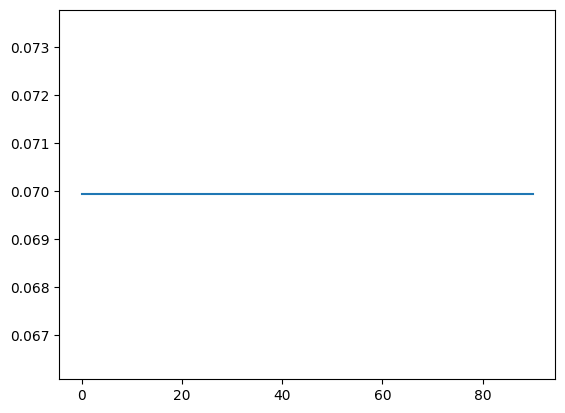

AttributeError: 'list' object has no attribute 'cpu'

In [84]:
train(passthru_data)

OK, cool, that converged pretty much instantly. Let's sanity check that this sounds OK.